<h1>Notebook de GMHI para CAMDA 2025</h1>

In [1]:
#Librerias que se utilizarán
# import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle

from GMHI_functions import *

In [2]:
tax=pd.read_csv('../../DataSets/CAMDA_2025/taxa.txt',sep='\t',index_col=0)
meta=pd.read_csv('../../DataSets/CAMDA_2025/metadata.txt',sep='\t')

In [3]:
tax

,train_0,train_1,train_2,train_3,train_4,train_5,train_6,train_7,train_8,train_9,...,train_4388,train_4389,train_4390,train_4391,train_4392,train_4393,train_4394,train_4395,train_4396,train_4397
#sample-id,,,,,,,,,,,,,,,,,,,,,
Bacteroides_vulgatus,11.66601,2.73563,12.44949,10.04475,7.68169,7.41403,2.10612,0.43836,0.67724,2.27049,...,16.16002,84.97335,5.81158,0.18158,10.80066,0.12498,7.38215,9.87256,34.63441,11.67750
Roseburia_faecis,0.00000,0.00000,0.00000,0.24374,4.10589,1.37947,0.78747,3.13218,10.80664,1.06868,...,0.66276,0.00827,0.03672,4.94094,0.84947,0.29030,0.02743,0.01955,0.00000,0.00964
Ruminococcus_gnavus,0.59774,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.60347,0.04162,0.30747,0.10444,0.00000,0.00172,0.29646,2.59479,0.60770
Roseburia_intestinalis,17.31798,0.18250,5.60477,3.53356,0.50953,5.28531,0.00000,5.61191,0.26558,0.00160,...,1.17488,0.00565,0.23012,0.92168,0.08458,0.28876,1.18431,0.00395,0.00000,5.36433
Blautia_wexlerae,0.00000,0.03673,0.03077,0.00000,0.00914,0.26341,0.00000,0.00000,0.90261,0.00000,...,0.04031,0.30255,0.02733,0.02141,0.06950,0.00489,0.04333,0.03602,0.00318,0.04264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Geobacillus_stearothermophilus,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Corynebacterium_falsenii,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Mycobacterium_avium,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


<h2>En previos intentos, se intentó entrenar GMHI con todos los datos pero fue poco eficiente. De manera que se separan por diversos grupos a las enfermedades</h2>

In [4]:
meta['category'].unique()

array(['healthy', 'PD', 'acute_diarrhoea', 'CRC', 'adenoma', 'IBD', 'CD',
       'UC', 'IGT', 'IGT;respiratoryinf', 'T2D', 'T2D;respiratoryinf',
       'recipient_before', 'ACVD', 'metabolic_syndrome', 'CAD', 'IGT;MS',
       'CAD;T2D', 'HF;CAD', 'HF;CAD;T2D', 'ME/CFS', 'cirrhosis', 'STH',
       'CRC;hypercholesterolemia', 'adenoma;hypertension',
       'adenoma;hypercholesterolemia', 'CRC;hypertension',
       'CRC;cholesterolemia', 'T2D;adenoma', 'adenoma;metastases',
       'CRC;hypercholesterolemia;hypertension',
       'adenoma;hypercholesterolemia;metastases', 'CRC;metastases',
       'few_polyps', 'BD', 'CRC;T2D', 'schizophrenia'], dtype=object)

<h2>Así, tenemos los seis siguientes seis grupos de diagnostico:</h2>

In [5]:
# Trastornos Metabólicos / Endocrinos
metabolicos_endocrinos = {
    "T2D",
    "IGT",
    "metabolic_syndrome"
}

# Trastornos Gastrointestinales
gastrointestinales = {
    "acute_diarrhoea",
    "CRC",
    "adenoma",
    "IBD",
    "CD",
    "UC",
    "cirrhosis",
    "STH",
    "few_polyps"
}

# Trastornos Cardiovasculares
cardiovasculares = {
    "ACVD",
    "CAD"
}

# Trastornos Neurológicos / Neurodegenerativos
neurologicos = {
    "PD",
    "ME/CFS"
}

# Trastornos Psiquiátricos
psiquiatricos = {
    "BD",
    "schizophrenia"
}

# Estado de Salud General
estado_salud = {
    "healthy"
}



<h2>Creamos test1 para entrenar el GMHI con los datos 2025 de CAMDA. Se consideran unicamente los gastrointestinales como el año pasado. </h2>

In [6]:
test1=gastrointestinales.union({"healthy"})
meta_test1=meta[meta['category'].isin(test1)].copy()
tax_test1=tax[meta_test1['sample']]
GMHI,MH,MN,accuracy=train_GMHI(meta_test1,tax_test1,1.3,0.021,1.27,0.076,sample_name='sample',control='healthy',disease_name='category')

|MH|= 28
|MN|= 32
(0.701643931444561, 0.6860477809547177)


<h3>Podemos probar su efectividad con los datos del año pasado</h3>

In [7]:
tax_camda_2024=pd.read_csv('../../DataSets/CAMDA/taxonomy.csv',index_col=0)
meta_camda_2024=pd.read_csv('../../DataSets/CAMDA/metadata.csv')
get_accuracy(get_all_GMHI(tax_camda_2024,MH,MN),meta_camda_2024)

(0.6704730831973899, 0.6790894568690096)

<h4>Este resultado es decente, de hecho el GMHI del articulo tiene aproximadamente esta efectividad con el set de datos que ellos usaron para probar su índice</h4>

## El funcionamiento del GMHI a grandes rasgos se basa en 
* Identificar conjuntos de especies saludables y no saludables
* Hacer una "diferencia" entre la riqueza de las especies saludables y no saludables en la taxonomia de la muestra 
* Si esta diferencia es mayor a 0, se predice una muestra saludable. Si es menor que 0, es no saludable y para el 0 el índice no llega a una conclusión.

<h3>Con este razonamiento, supongamos que una enfermedad gastrointestinal es saludable y el conjunto de metabolicos endocrinos no lo es. Entrenando el GMHI con este razonamiento tenemos lo siguiente: </h3>

In [8]:
test2=gastrointestinales.union(metabolicos_endocrinos)
meta_test2=meta[meta['category'].isin(test2)].copy()
tax_test2=tax[meta_test2['sample']]
meta_test2.loc[meta_test2[meta_test2['category'].isin(metabolicos_endocrinos)].index,'category']='IGT'
GMHI,MH,MN,accuracy=train_GMHI(meta_test2,tax_test2,1.3,0.021,1.27,0.076,sample_name='sample',control='IGT',disease_name='category')

|MH|= 33
|MN|= 44
(0.6970156803237229, 0.7179201366322567)


<h4>Como vemos, no es un mal resultado, es cercano a lo anterior. Además, aún se deben ajustar los parámetros para un mejor rendimiento.</h4>

<h2>¿Qué pasa si entrenamos el GMHI para todas las combinaciones de grupos de salud?</h2>

In [9]:
categories=[[metabolicos_endocrinos,'met_endoc'],[cardiovasculares,'cardiov']
            ,[psiquiatricos,'psic'],[neurologicos,'neuro'],[gastrointestinales,'gastro'],[estado_salud,'saludable']]

In [10]:
import warnings
warnings.filterwarnings('ignore')
df_tax=pd.DataFrame(columns=['met_endoc','cardiov','psic','neuro','gastro','saludable'],
                index=['met_endoc','cardiov','psic','neuro','gastro','saludable'],data=0)
for category_1 in categories:
    category_1_name=category_1[1]
    category_1_diseases=category_1[0]
    cat_1_representant=list(category_1_diseases)[0]
    for category_2 in categories:
        category_2_name=category_2[1]
        category_2_diseases=category_2[0]
        if category_1_name==category_2_name:
            continue
        

        
        print('se comparan',category_1_name,'y',category_2_name)
        diseases_set=category_1_diseases.union(category_2_diseases)
        meta_test=meta[meta['category'].isin(diseases_set)].copy()
        tax_test=tax[meta_test['sample']]

        meta_test.loc[meta_test[meta_test['category'].isin(category_1_diseases)].index,'category']=cat_1_representant
        GMHI,MH,MN,accuracy=train_GMHI(meta_test,tax_test,1.3,0.021,1.27,0.076,sample_name='sample',control=cat_1_representant,disease_name='category')
        df_tax.loc[category_1_name,category_2_name]=accuracy[0]

se comparan met_endoc y cardiov
|MH|= 59
|MN|= 78
(0.6547972304648862, 0.7297673656618611)
se comparan met_endoc y psic
|MH|= 102
|MN|= 59
(0.10827250608272507, 0.5203145478374837)
se comparan met_endoc y neuro
|MH|= 83
|MN|= 38
(0.19110576923076922, 0.5596330275229358)
se comparan met_endoc y gastro
|MH|= 33
|MN|= 44
(0.6970156803237229, 0.7179201366322567)
se comparan met_endoc y saludable
|MH|= 24
|MN|= 17
(0.6769102990033222, 0.6297732913192604)
se comparan cardiov y met_endoc
|MH|= 111
|MN|= 30
(0.744807121661721, 0.7588070223650276)
se comparan cardiov y psic
|MH|= 96
|MN|= 42
(0.33876221498371334, 0.5907258064516129)
se comparan cardiov y neuro
|MH|= 100
|MN|= 47
(0.6782334384858044, 0.7891245909303413)
se comparan cardiov y gastro
|MH|= 111
|MN|= 27
(0.6764705882352942, 0.7297888877079237)
se comparan cardiov y saludable
|MH|= 117
|MN|= 23
(0.7337559429477021, 0.7286682517893912)
se comparan psic y met_endoc
|MH|= 70
|MN|= 50
(0.3588807785888078, 0.6546526867627785)
se comparan

<h3>Obtenemos resultados llamativos, pues aún no se han ajustados los parámetros. Se usaron únicamente 1.3,0.021,1.27,0.076 para todos los grupos. Hay que notar que no se tienen resultados simétricos.</h3>

<h2>Esto es igual útil para los pathways</h2>

<Axes: >

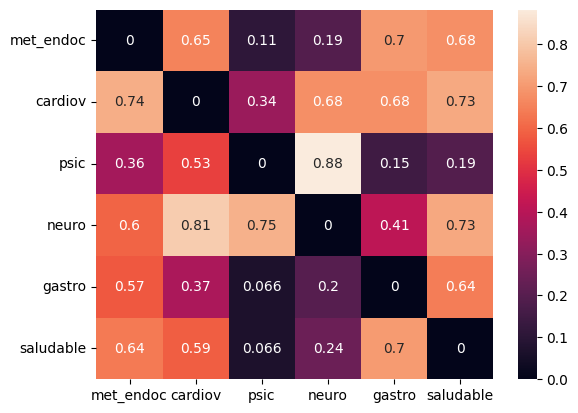

In [11]:
import seaborn as sns
sns.heatmap(df_tax, annot=True)

In [12]:
path=pd.read_csv('../../DataSets/CAMDA_2025/pathways.txt',sep='\t',index_col=0)

In [21]:
import warnings
warnings.filterwarnings('ignore')
df_path=pd.DataFrame(columns=['met_endoc','cardiov','psic','neuro','gastro','saludable'],
                index=['met_endoc','cardiov','psic','neuro','gastro','saludable'],data=0)
for category_1 in categories:
    category_1_name=category_1[1]
    category_1_diseases=category_1[0]
    cat_1_representant=list(category_1_diseases)[0]
    for category_2 in categories:
        category_2_name=category_2[1]
        category_2_diseases=category_2[0]
        if category_1_name==category_2_name:
            continue
        

        
        print('se comparan',category_1_name,'y',category_2_name)
        diseases_set=category_1_diseases.union(category_2_diseases)
        meta_test=meta[meta['category'].isin(diseases_set)].copy()
        path_test=path[meta_test['sample']]

        meta_test.loc[meta_test[meta_test['category'].isin(category_1_diseases)].index,'category']=cat_1_representant
        GMHI,MH,MN,accuracy=train_GMHI(meta_test,path_test,0.5,.0001,0.04,0.0002,sample_name='sample',control=cat_1_representant,disease_name='category')
        df_path.loc[category_1_name,category_2_name]=accuracy[0]

se comparan met_endoc y cardiov
|MH|= 31
|MN|= 100
(0.7566765578635015, 0.5053930791020167)
se comparan met_endoc y psic
|MH|= 0
|MN|= 122
(nan, 0.5)
se comparan met_endoc y neuro
|MH|= 115
|MN|= 16
(0.9158653846153846, 0.49934469200524245)
se comparan met_endoc y gastro
|MH|= 77
|MN|= 79
(0.3859382903388973, 0.5)
se comparan met_endoc y saludable
|MH|= 48
|MN|= 90
(0.3168604651162791, 0.5)
se comparan cardiov y met_endoc
|MH|= 100
|MN|= 19
(0.7576656775469832, 0.5060483870967742)
se comparan cardiov y psic
|MH|= 0
|MN|= 57
(nan, 0.5)
se comparan cardiov y neuro
|MH|= 112
|MN|= 0
(nan, 0.5)
se comparan cardiov y gastro
|MH|= 116
|MN|= 22
(0.17236662106703146, 0.5016474464579901)
se comparan cardiov y saludable
|MH|= 101
|MN|= 30
(0.8631801373481247, 0.5000808902833611)
se comparan psic y met_endoc
|MH|= 122
|MN|= 0
(nan, 0.5)
se comparan psic y cardiov
|MH|= 57
|MN|= 0
(nan, 0.5)
se comparan psic y neuro
|MH|= 97
|MN|= 0
(nan, 0.5)
se comparan psic y gastro
|MH|= 133
|MN|= 5
(0.0471327

<h2>Estos resultados pueden ser útiles, vemos muchos valores decentes y para los nan se debe a los parámetros, pues algunos requieren parámetros más relajados para encontrar los conjuntos no vacios de especies importantes</h2>

<Axes: >

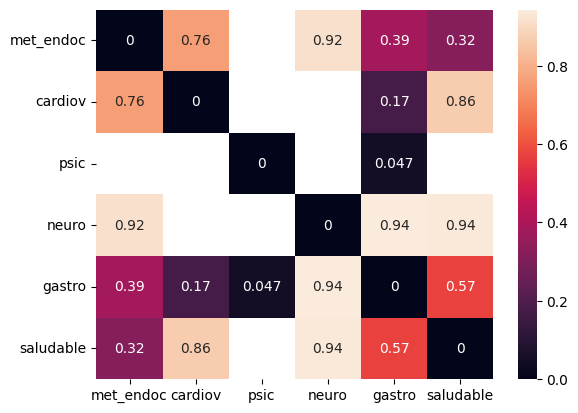

In [22]:
sns.heatmap(df_path, annot=True)

<h2>Con esta información, se puede hacer lo siguiente:</h2>

In [23]:
final=pd.DataFrame(columns=['GMHI_tax_psic_vs_neuro','GMHI_tax_psic_vs_gastro','...','GMHI_path_psic_vs_gastro','objetivo'],
            index=['sample_1','sample_2','...'])
final.loc['sample_1','GMHI_tax_psic_vs_neuro']=-0.9
final.loc['sample_2','GMHI_tax_psic_vs_neuro']=0.23121312
final.loc['sample_1','GMHI_tax_psic_vs_gastro']=-0.555
final.loc['sample_2','GMHI_tax_psic_vs_gastro']=1.2
final.loc['sample_1','objetivo']='Psicologico'
final.loc['sample_2','objetivo']='Gastrointestinal'
final

,GMHI_tax_psic_vs_neuro,GMHI_tax_psic_vs_gastro,...,GMHI_path_psic_vs_gastro,objetivo
sample_1,-0.9,-0.555,NaN,NaN,Psicologico
sample_2,0.231213,1.2,NaN,NaN,Gastrointestinal
...,NaN,NaN,NaN,NaN,NaN


<h3>Con este data frame se podría realizar un modelo de machine learning para las múltiples categorias. Antes hay que ajustar parámetros y llegar a un consenso de qué grupos se considerarían para GMHI positivo o negativo</h3>